<a href="https://colab.research.google.com/github/tsakailab/iip/blob/main/colab/iip_local_operations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 畳み込みによる局所演算

画像がもつ情報は，局所的な特徴（断片的な形状，模様，配色）の組合せによって表されています．**畳み込み（convolution）**は，画像の**局所特徴（local features）**の量を算出する基本的な演算です．

[[Fidler+,CVPR08]](https://doi.org/10.1109/CVPR.2008.4587409)
[[Lee+, ICML09]](https://doi.org/10.1145/1553374.1553453)
<div>
<img src="https://d3i71xaburhd42.cloudfront.net/c09c802d6eb88ef9e29788df47247c9a329eac7c/3-Figure1-1.png" width="400"/>
<img src="https://www.researchgate.net/profile/Saad-Albawi/publication/319253577/figure/fig1/AS:615410118455298@1523736614895/Learned-features-from-a-Convolutional-Neural-Network.png" width="300"/>
</div>

## まずは小さな濃淡画像で試します．

In [1]:
#@title 手書き数字データセットMNISTを読み込みます．
#簡単のため，colabにsample_dataフォルダに用意されているファイルを使います．
import pandas as pd
mnist = pd.read_csv('/content/sample_data/mnist_test.csv', header=None)

lbl = mnist.iloc[:,0].to_numpy()
imgs = mnist.drop(columns=0).to_numpy().reshape(-1,28,28)
print("(#images, height, width) =", imgs.shape)

(#images, height, width) = (10000, 28, 28)


In [2]:
i = 1234

Showing an image of digit 8 in shape (28, 28)


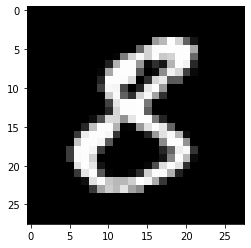

In [3]:
#@title i 番目の手書き数字画像を表示します．
img = imgs[i]
print("Showing an image of digit", lbl[i], "in shape", img.shape)

import matplotlib.pyplot as plt
plt.imshow(img, cmap='gray')
plt.show()

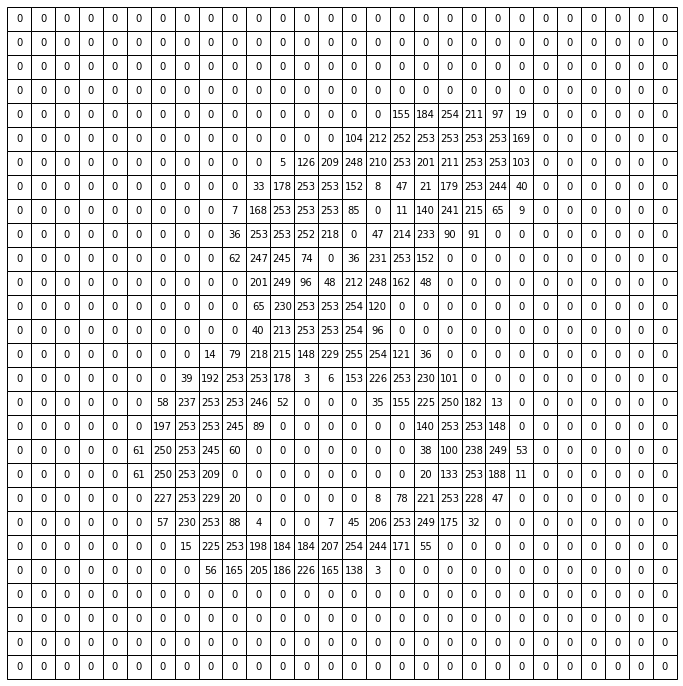

In [4]:
#@title 画像は数値（画素値）の集まりです．
import numpy as np
import matplotlib.pyplot as plt
plt.axis('off')
plt.table(np.round(img,1), cellLoc='center', loc='center').scale(2,2)
plt.show()

### 畳み込み（convolution）のカーネル（kernel）を設定します．

In [5]:
kernel = [[ -1,  0,  1],
          [ -2,  0,  2],
          [ -1,  0,  1]]

In [6]:
#@title PyTorchの畳み込み層 conv にカーネルを設定します．
import torch
ker = torch.tensor(kernel).unsqueeze(0).unsqueeze(0)

#Conv2d(in_channels, out_channels, kernel_size, options)
conv = torch.nn.Conv2d(1, 1, 3, bias=False, padding=1)
conv.weight = torch.nn.Parameter(ker.float())
#conv.bias = torch.nn.Parameter(torch.tensor([1000]).float())

print("(out_channels, in_channels, kernel height, kernel width) =", conv.weight.shape)
print("\"conv\" made by torch.nn.Conv2d:", conv.weight)

(out_channels, in_channels, kernel height, kernel width) = torch.Size([1, 1, 3, 3])
"conv" made by torch.nn.Conv2d: Parameter containing:
tensor([[[[-1.,  0.,  1.],
          [-2.,  0.,  2.],
          [-1.,  0.,  1.]]]], requires_grad=True)


Input:  <class 'torch.Tensor'> torch.Size([1, 1, 28, 28])
Output: <class 'torch.Tensor'> torch.Size([1, 1, 28, 28])


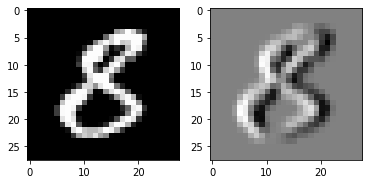

In [7]:
#@title 畳み込みを実行します．out_img = conv(in_img)
in_img = torch.tensor(img).unsqueeze(0).unsqueeze(0).float()
out_img = conv(in_img)

# (n, channels, height, width)
print("Input: ", type(in_img), in_img.shape)
print("Output:", type(out_img), out_img.shape)

plt.subplot(1,2,1)
plt.imshow(in_img[0,0].detach(), cmap='gray')

plt.subplot(1,2,2)
plt.imshow(out_img[0,0].detach(), cmap='gray')
plt.show()

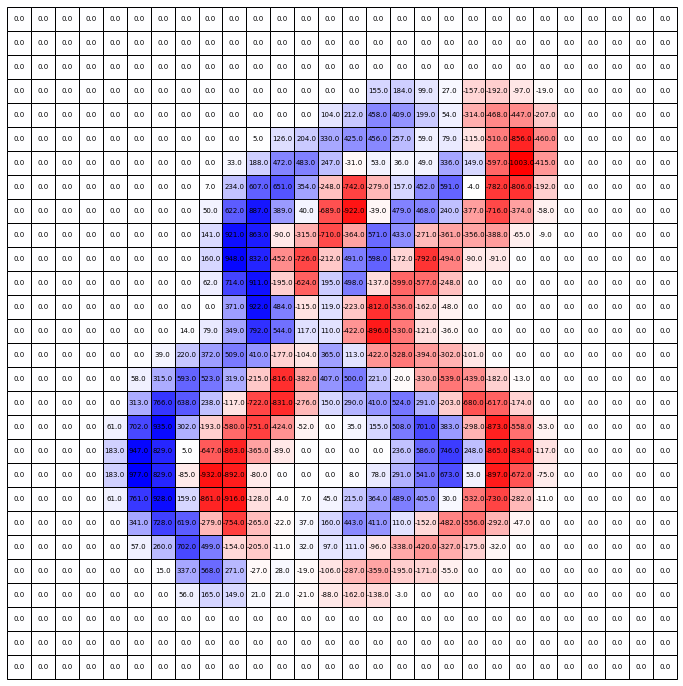

In [8]:
#@title 出力を観察しましょう．
from matplotlib.colors import TwoSlopeNorm as tsn

fmap = out_img[0,0].detach().numpy()
norm = tsn(vmin=np.minimum(fmap.min(),-1e-6), vcenter=0, vmax=np.maximum(fmap.max(),1e-3))

plt.axis('off')
tbl = plt.table(np.round(fmap,0), cellLoc='center', loc='center', 
                cellColours=plt.get_cmap('bwr_r')(norm(fmap)))
tbl.scale(2,2)
tbl.auto_set_font_size(False)
tbl.set_fontsize(7)
plt.show()

## 次は，カラー画像で試します．

In [9]:
uri = "https://upload.wikimedia.org/wikipedia/commons/thumb/1/17/RYB_Color_wheel.png/320px-RYB_Color_wheel.png"

(height, width, channels) = (240, 320, 3)


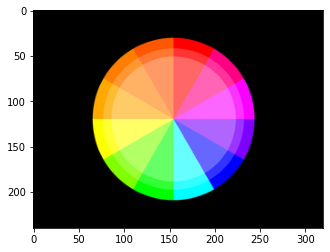

In [10]:
#@title 画像をダウンロードして表示します．
import imageio
cimg = imageio.imread(uri)

print("(height, width, channels) =", cimg.shape)

import matplotlib.pyplot as plt
plt.imshow(cimg)
plt.show()

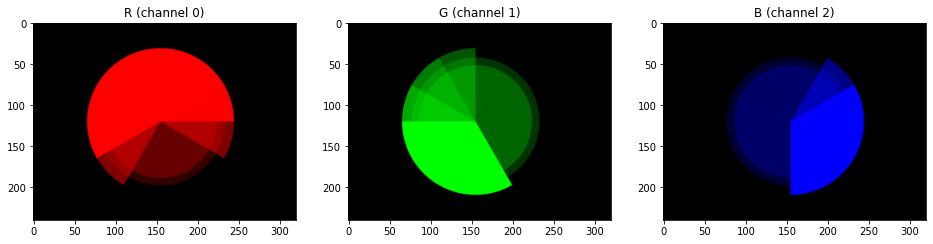

In [11]:
#@title カラー画像は画素値 (R,G,B) の集まりで表されています．
import numpy as np
from matplotlib.colors import LinearSegmentedColormap as lsc

plt.figure(figsize=(16,48))

plt.subplot(1,3,1)
plt.title("R (channel 0)")
plt.imshow(cimg[:,:,0], cmap=lsc.from_list('kr', [(0,0,0), (1,0,0)], N=255))

plt.subplot(1,3,2)
plt.title("G (channel 1)")
plt.imshow(cimg[:,:,1], cmap=lsc.from_list('kg', [(0,0,0), (0,1,0)], N=255))

plt.subplot(1,3,3)
plt.title("B (channel 2)")
plt.imshow(cimg[:,:,2], cmap=lsc.from_list('kb', [(0,0,0), (0,0,1)], N=255))

plt.show()

### 畳み込み（convolution）のカーネル（kernel）を設定します．

R, G, B それぞれに kernel_ch0, kernel_ch1, kernel_ch2 を用意します．

In [12]:
kernel_ch0 = [[ -1, -2, -1],
              [  0,  0,  0],
              [  1,  2,  1]]

kernel_ch1 = [[  0,  0,  0],
              [  0,  0,  0],
              [  0,  0,  0]]

kernel_ch2 = [[  0,  0,  0],
              [  0,  0,  0],
              [  0,  0,  0]]

In [13]:
#@title PyTorchの畳み込み層にカーネルを設定します．
import torch
ker = torch.tensor([kernel_ch0, kernel_ch1, kernel_ch2]).unsqueeze(0)

#Conv2d(in_channels, out_channels, kernel_size, options)
conv = torch.nn.Conv2d(3, 1, 3, bias=False, padding=1)
conv.weight = torch.nn.Parameter(ker.float())
print("(out_channels, in_channels, kernel height, kernel width) =", conv.weight.shape)
print("\"conv\" made by torch.nn.Conv2d:", conv.weight)

(out_channels, in_channels, kernel height, kernel width) = torch.Size([1, 3, 3, 3])
"conv" made by torch.nn.Conv2d: Parameter containing:
tensor([[[[-1., -2., -1.],
          [ 0.,  0.,  0.],
          [ 1.,  2.,  1.]],

         [[ 0.,  0.,  0.],
          [ 0.,  0.,  0.],
          [ 0.,  0.,  0.]],

         [[ 0.,  0.,  0.],
          [ 0.,  0.,  0.],
          [ 0.,  0.,  0.]]]], requires_grad=True)


Input:  <class 'torch.Tensor'> torch.Size([1, 3, 240, 320])
Output: <class 'torch.Tensor'> torch.Size([1, 1, 240, 320])


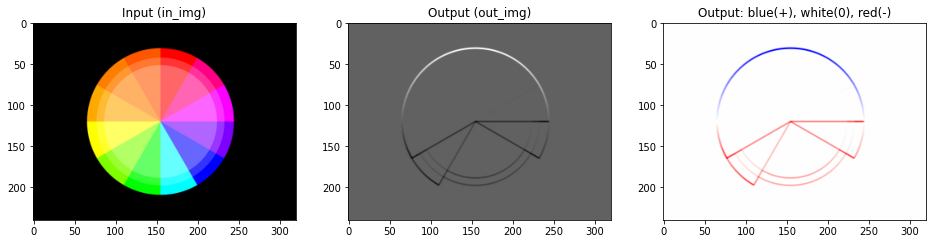

In [14]:
#@title 畳み込みを実行します．out_img = conv(in_img)
in_img = torch.tensor(cimg).permute(2,0,1).unsqueeze(0).float()
out_img = conv(in_img)

# (n, channels, height, width)
print("Input: ", type(in_img), in_img.shape)
print("Output:", type(out_img), out_img.shape)

plt.figure(figsize=(16,48))
plt.subplot(1,3,1)
plt.title("Input (in_img)")
plt.imshow(in_img[0].detach().permute(1,2,0).to(torch.int))

fmap = out_img[0,0].detach().numpy()
plt.subplot(1,3,2)
plt.title("Output (out_img)")
plt.imshow(fmap, cmap='gray')

from matplotlib.colors import TwoSlopeNorm as tsn
norm = tsn(vmin=np.minimum(fmap.min(),-1e-6), vcenter=0, vmax=np.maximum(fmap.max(),1e-3))
plt.subplot(1,3,3)
plt.title("Output: blue(+), white(0), red(-)")
plt.imshow(fmap, cmap='bwr_r', norm=norm)

plt.show()